In [2]:
import time
import pandas as pd
import requests
import re
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup, element

In [115]:
def main_fun(city, page_num):
    # Get the HTML from the page
    url = 'https://www.otodom.pl'
    res = requests.get(url)
    soup = BeautifulSoup(res.text, 'html.parser')
    # search input
    key = city
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    driver.get(url)
    time.sleep(2)
    # full screen window 
    driver.maximize_window()
    #cookie click
    cookie_click = driver.find_element(By.XPATH, '//*[@id="onetrust-accept-btn-handler"]')
    cookie_click.click()
    time.sleep(2)
    #search bar click
    search_bar = driver.find_element(By.XPATH, '//*[@id="location"]/div[2]')
    search_bar.click()
    time.sleep(2)
    #search entry
    search_entry = driver.find_element(By.XPATH, '//*[@id="location-picker-input"]')
    search_entry.send_keys(key)
    time.sleep(2)
    #search select
    search_select = driver.find_element(By.XPATH, '//*[@id="__next"]/main/section/div/div/form/div/div[1]/div[3]/div/div[1]/div/div[2]/ul/li[1]/label[1]')
    search_select.click()
    time.sleep(2)
    #search button press
    search_button = driver.find_element(By.XPATH, '//*[@id="search-form-submit"]')
    search_button.click()
    time.sleep(5)
    # getting apartments data    
    url = driver.current_url 
    res = requests.get(url)
    time.sleep(2)
    # 72 per page    
    driver.find_element(By.XPATH, '/html/body/div[1]/div[2]/main/div/div[2]/div[1]/div[4]/div/div/div/div/div').click()
    time.sleep(2)
    driver.find_element(By.XPATH, '/html/body/div[1]/div[2]/main/div/div[2]/div[1]/div[4]/div/div/div/div/div[2]/div/div[4]').click() 
    time.sleep(3)
    df_otodom = pd.DataFrame()

    j = 3

    for i in range(0, page_num):
        if page_num == 1:
            # scroll to bottom
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(2)
            df_otodom = pd.DataFrame()
            # getting apartments data
            url = driver.current_url
            res = requests.get(url)
            time.sleep(3)
            # scroll to bottom
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(2)
            soup = BeautifulSoup(driver.page_source, 'html.parser')
            apartment = soup.find_all('li', {'class': 'css-iq9jxc e1n6ljqa1'})
            apt: element.Tag
            apartments = list()
            for apt in apartment:
                try:
                    apartments.append({
                        'name': apt.find('h3', {'class': 'css-1mmyqk7 e1n6ljqa6'}).text,
                        'city': key,
                        'price': apt.find('span', {'class': 'css-1ntk0hg ei6hyam1'}).text,
                        'rooms': apt.find('div', {'class': 'e1n6ljqa19 css-6vtodn ei6hyam0'}).find_all('span')[2].get_text(),
                        'area': (apt.find('div', {'class': 'e1n6ljqa19 css-6vtodn ei6hyam0'}).find_all('span')[3].get_text()),
                        'price_per_m2': apt.find('div', {'class': 'e1n6ljqa19 css-6vtodn ei6hyam0'}).find_all('span')[1].get_text(),
                        'link': url + apt.find('a', {'class': 'css-1up0y1q e1n6ljqa16'}).get('href')
                    })
                except:
                    pass
            df = pd.DataFrame(apartments)
            # df link column to list
            links = df['link'].tolist()
            good_links = list()
            for i in range(len(links)):
                url = links[i]
                prefix = 'https://www.otodom.pl'
                suffix = url.split('/oferta/')[-1]
                result = prefix + '/oferta/' + suffix
                good_links.append(result)

            # replace df link column with good_links
            df['link'] = good_links
            
            additions = list()
            for x in range(len(df['link'])):
                url = df['link'][x]
                res = requests.get(url)
                soup = BeautifulSoup(res.text, 'html.parser')
                try:
                    forma_wlasnosci = soup.find('div', {'aria-label': 'Forma własności'}).find_all('div')[3].text
                except:
                    forma_wlasnosci = None
                    
                try:
                    stan_wykonczenia = soup.find('div', {'aria-label': 'Stan wykończenia'}).find_all('div')[3].text
                except:
                    stan_wykonczenia = None
                    
                try:
                    pietro = soup.find('div', {'aria-label': 'Piętro'}).find_all('div')[3].text
                except:
                    pietro = None
                    
                try:
                    balkon = soup.find('div', {'aria-label': 'Balkon / ogród / taras'}).find_all('div')[3].text
                except:
                    balkon = None
                    
                try:
                    czynsz = soup.find('div', {'aria-label': 'Czynsz'}).find_all('div')[3].text
                except:
                    czynsz = None
                
                try:
                    parking = soup.find('div', {'aria-label': 'Miejsce parkingowe'}).find_all('div')[3].text
                except:
                    parking = None
                    
                try:
                    ogrzewanie = soup.find('div', {'aria-label': 'Ogrzewanie'}).find_all('div')[3].text
                except:
                    ogrzewanie = None
                
                additions.append({
                'forma_wlasnosci': forma_wlasnosci,
                'stan_wykonczenia': stan_wykonczenia,
                'pietro': pietro,
                'balkon': balkon,
                'czynsz': czynsz,
                'parking': parking,
                'ogrzewanie': ogrzewanie
                })
            df = df.join(pd.DataFrame(additions))
            df_otodom = df_otodom.append(df)
        else:
               # scroll to bottom
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(2)
                # getting apartments data
                url = driver.current_url
                res = requests.get(url)
                time.sleep(3)
                ##scroll to bottom
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(2)
                soup = BeautifulSoup(driver.page_source, 'html.parser')
                apartment = soup.find_all('li', {'class': 'css-iq9jxc e1n6ljqa1'})
                apt: element.Tag
                apartments = list()
                for apt in apartment:
                    try:
                        apartments.append({
                            'name': apt.find('h3', {'class': 'css-1mmyqk7 e1n6ljqa6'}).text,
                            'city': key,
                            'price': apt.find('span', {'class': 'css-1ntk0hg ei6hyam1'}).text,
                            'rooms': apt.find('div', {'class': 'e1n6ljqa19 css-6vtodn ei6hyam0'}).find_all('span')[2].get_text(),
                            'area': (apt.find('div', {'class': 'e1n6ljqa19 css-6vtodn ei6hyam0'}).find_all('span')[3].get_text()),
                            'price_per_m2': apt.find('div', {'class': 'e1n6ljqa19 css-6vtodn ei6hyam0'}).find_all('span')[1].get_text(),
                            'link': url + apt.find('a', {'class': 'css-1up0y1q e1n6ljqa16'}).get('href')
                        })
                    except:
                        pass
                df = pd.DataFrame(apartments)
                
                links = df['link'].tolist()
                good_links = list()
                for i in range(len(links)):
                    url = links[i]
                    prefix = 'https://www.otodom.pl'
                    suffix = url.split('/oferta/')[-1]
                    result = prefix + '/oferta/' + suffix
                    good_links.append(result)

                # replace df link column with good_links
                df['link'] = good_links
                
                additions = list()
                for x in range(len(df['link'])):
                    url = df['link'][x]
                    res = requests.get(url)
                    soup = BeautifulSoup(res.text, 'html.parser')
                    try:
                        forma_wlasnosci = soup.find('div', {'aria-label': 'Forma własności'}).find_all('div')[3].text
                    except:
                        forma_wlasnosci = None
                        
                    try:
                        stan_wykonczenia = soup.find('div', {'aria-label': 'Stan wykończenia'}).find_all('div')[3].text
                    except:
                        stan_wykonczenia = None
                        
                    try:
                        pietro = soup.find('div', {'aria-label': 'Piętro'}).find_all('div')[3].text
                    except:
                        pietro = None
                        
                    try:
                        balkon = soup.find('div', {'aria-label': 'Balkon / ogród / taras'}).find_all('div')[3].text
                    except:
                        balkon = None
                        
                    try:
                        czynsz = soup.find('div', {'aria-label': 'Czynsz'}).find_all('div')[3].text
                    except:
                        czynsz = None
                    
                    try:
                        parking = soup.find('div', {'aria-label': 'Miejsce parkingowe'}).find_all('div')[3].text
                    except:
                        parking = None
                        
                    try:
                        ogrzewanie = soup.find('div', {'aria-label': 'Ogrzewanie'}).find_all('div')[3].text
                    except:
                        ogrzewanie = None
                    
                    additions.append({
                    'forma_wlasnosci': forma_wlasnosci,
                    'stan_wykonczenia': stan_wykonczenia,
                    'pietro': pietro,
                    'balkon': balkon,
                    'czynsz': czynsz,
                    'parking': parking,
                    'ogrzewanie': ogrzewanie
                    })
                df = df.join(pd.DataFrame(additions))
                df_otodom = df_otodom.append(df)

                # scroll to top                                   
                driver.execute_script("window.scrollTo(document.body.scrollHeight,0);")
                time.sleep(2)

                if j < 6:
                    driver.find_element(By.XPATH, f'/html/body/div[1]/div[2]/main/div/div[2]/div[1]/div[4]/div/nav/button[{j}]').click()           
                    time.sleep(3)
                    j = j+1
                else:
                    driver.find_element(By.XPATH, f'/html/body/div[1]/div[2]/main/div/div[2]/div[1]/div[4]/div/nav/button[7]').click()
                    time.sleep(3)
                continue
    df_otodom.drop_duplicates(subset=['name', 'link'], inplace=True)
    df_otodom.reset_index(drop=True, inplace=True)
    return df_otodom

In [121]:
otodom_main = main_fun('Warszawa', 15)

C:\Users\zapas\AppData\Local\Temp\ipykernel_37920\2417564551.py:233: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_otodom = df_otodom.append(df)
C:\Users\zapas\AppData\Local\Temp\ipykernel_37920\2417564551.py:233: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_otodom = df_otodom.append(df)
C:\Users\zapas\AppData\Local\Temp\ipykernel_37920\2417564551.py:233: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_otodom = df_otodom.append(df)
C:\Users\zapas\AppData\Local\Temp\ipykernel_37920\2417564551.py:233: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_otodom = df_otodom.append(df)
C:\Users\zapas\AppData\Local\Temp\ipykernel_37920\24

In [122]:
otodom_main

,name,city,price,rooms,area,price_per_m2,link,forma_wlasnosci,stan_wykonczenia,pietro,balkon,czynsz,parking,ogrzewanie
0,Najtańsze 3 pokoje na Ochocie ! Blisko centrum !,Warszawa,649 000 zł,3 pokoje,55.2 m²,11 757 zł/m²,https://www.otodom.pl/oferta/najtansze-3-pokoj...,pełna własność,do remontu,1/8,balkon,350 zł,None,miejskie
1,"Warszawa Śródmieście, bezpośrednio, obok Łazienek",Warszawa,825 000 zł,2 pokoje,43.5 m²,18 966 zł/m²,https://www.otodom.pl/oferta/warszawa-srodmies...,pełna własność,do zamieszkania,3/4,balkon,660 zł,None,miejskie
2,"Mieszkanie 3 pok. 64m2 Tarchomin, bezpośrednio.",Warszawa,595 000 zł,3 pokoje,64 m²,9297 zł/m²,https://www.otodom.pl/oferta/mieszkanie-3-pok-...,pełna własność,do wykończenia,2/3,balkon,650 zł,garaż/miejsce parkingowe,kotłownia
3,4-pokojowe mieszkanie 96m2 + balkon,Warszawa,1 585 650 zł,4 pokoje,96.1 m²,16 500 zł/m²,https://www.otodom.pl/oferta/4-pokojowe-mieszk...,pełna własność,do wykończenia,1/2,balkon,None,garaż/miejsce parkingowe,None
4,4-pokojowe mieszkanie 88m2 + taras Bezpośrednio,Warszawa,1 201 365 zł,4 pokoje,88.99 m²,13 500 zł/m²,https://www.otodom.pl/oferta/4-pokojowe-mieszk...,pełna własność,do wykończenia,4/4,taras,None,garaż/miejsce parkingowe,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,3-pokojowe mieszkanie 58m2 + balkon Bezpośrednio,Warszawa,Zapytaj o cenę,3 pokoje,58.72 m²,,https://www.otodom.pl/oferta/3-pokojowe-mieszk...,pełna własność,do wykończenia,1/2,balkon,None,garaż/miejsce parkingowe,None
252,3-pokojowe mieszkanie 56m2 + balkon Bezpośrednio,Warszawa,Zapytaj o cenę,3 pokoje,56.6 m²,,https://www.otodom.pl/oferta/3-pokojowe-mieszk...,pełna własność,do wykończenia,parter/2,balkon,None,garaż/miejsce parkingowe,None
253,Znakomita LOKALIZACJA*świetna INWESTYCJA**3 po...,Warszawa,918 000 zł,3 pokoje,51.3 m²,17 895 zł/m²,https://www.otodom.pl/oferta/znakomita-lokaliz...,pełna własność,do zamieszkania,1/9,balkon,742 zł,None,miejskie
254,3-pokojowe mieszkanie 60m2 + balkon Bez Prowizji,Warszawa,Zapytaj o cenę,3 pokoje,60.83 m²,,https://www.otodom.pl/oferta/3-pokojowe-mieszk...,pełna własność,do wykończenia,parter/2,balkon,None,garaż/miejsce parkingowe,None


In [13]:
#del zł 
df=otodom_main
df['price']=df['price'].str.replace('zł', '')
df['price']=df['price'].str.replace(' ', '')
df['czynsz']=df['czynsz'].str.replace('zł', '')
df['czynsz']=df['czynsz'].str.replace(' ', '')
df['price_per_m2']=df['price_per_m2'].str.replace('zł/m²', '')
df['price_per_m2']=df['price_per_m2'].str.replace(' ', '')
df['price']=df['price'].str.replace(' ', '')
df['area']=df['area'].str.replace('m²', '')
df['area']=df['area'].str.replace(' ', '')
df

,name,city,price,rooms,area,price_per_m2,link,forma_wlasnosci,stan_wykonczenia,pietro,balkon,czynsz,parking,ogrzewanie
0,Mieszkanie 56m² z ogrodem 32m²,Warszawa,485 112,3 pokoje,56,8663,https://www.otodom.pl/oferta/mieszkanie-56m-z-...,None,do wykończenia,parter/2,None,None,None,None
1,"Warszawa Śródmieście, bezpośrednio, obok Łazienek",Warszawa,825 000,2 pokoje,43.5,18 966,https://www.otodom.pl/oferta/warszawa-srodmies...,pełna własność,do zamieszkania,3/4,balkon,660,None,miejskie
2,"Sprzedam, kameralne 2 pokojowe mieszkanie 37 m2",Warszawa,500 000,2 pokoje,37,13 514,https://www.otodom.pl/oferta/sprzedam-kameraln...,spółdzielcze wł. z KW,do remontu,3/4,balkon,450,None,miejskie
3,"Jasna kawalerka na Żoliborzu, idealna pod wyna...",Warszawa,433 000,1 pokój,25.5,16 980,https://www.otodom.pl/oferta/jasna-kawalerka-n...,spółdzielcze własnościowe,do zamieszkania,2/4,None,320,None,miejskie
4,"Mieszkanie 2 pok. na Mokotowie, BEZ POŚREDNIKÓW",Warszawa,550 000,2 pokoje,39.2,14 031,https://www.otodom.pl/oferta/mieszkanie-2-pok-...,pełna własność,None,1/10,balkon,700,garaż/miejsce parkingowe,miejskie
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,Mieszkanie na Woli przy Metrze Księcia Janusza,Warszawa,585 000,3 pokoje,38,15 395,https://www.otodom.pl/oferta/mieszkanie-na-wol...,spółdzielcze własnościowe,do zamieszkania,None,None,600,None,miejskie
743,Apartament gotowy do wprowadzenia | Stara Ochota,Warszawa,1 499 000,5 pokoi,103.8,14 441,https://www.otodom.pl/oferta/apartament-gotowy...,pełna własność,do zamieszkania,10/16,None,1200,garaż/miejsce parkingowe,miejskie
744,"Złota, rozkładowe 3 pokoje z garażem",Warszawa,850 000,3 pokoje,67.64,12 567,https://www.otodom.pl/oferta/zlota-rozkladowe-...,spółdzielcze własnościowe,do remontu,4/7,balkon,900,garaż/miejsce parkingowe,miejskie
745,Kawalerka | Zielona i spokojna okolica,Warszawa,360 000,1 pokój,37,9730,https://www.otodom.pl/oferta/kawalerka-zielona...,pełna własność,do remontu,4/4,None,500,None,miejskie


In [99]:
df = pd.read_csv('otodom.csv')

In [100]:
import numpy as np
import re

df['price'] = [re.sub(r'\D', '', s) for s in df['price']]
#empty space as none
df['price'] = df['price'].replace('', np.nan)
df['price'] = df['price'].astype(float)
#price as numeric
df['price'] = pd.to_numeric(df['price'])
df

,name,city,price,rooms,area,price_per_m2,link,forma_wlasnosci,stan_wykonczenia,pietro,balkon,czynsz,parking,ogrzewanie
0,Mieszkanie 56m² z ogrodem 32m²,Warszawa,485112.0,3 pokoje,56.00,8663,https://www.otodom.pl/oferta/mieszkanie-56m-z-...,NaN,do wykończenia,parter/2,NaN,NaN,NaN,NaN
1,"Warszawa Śródmieście, bezpośrednio, obok Łazienek",Warszawa,825000.0,2 pokoje,43.50,18 966,https://www.otodom.pl/oferta/warszawa-srodmies...,pełna własność,do zamieszkania,3/4,balkon,660,NaN,miejskie
2,"Sprzedam, kameralne 2 pokojowe mieszkanie 37 m2",Warszawa,500000.0,2 pokoje,37.00,13 514,https://www.otodom.pl/oferta/sprzedam-kameraln...,spółdzielcze wł. z KW,do remontu,3/4,balkon,450,NaN,miejskie
3,"Jasna kawalerka na Żoliborzu, idealna pod wyna...",Warszawa,433000.0,1 pokój,25.50,16 980,https://www.otodom.pl/oferta/jasna-kawalerka-n...,spółdzielcze własnościowe,do zamieszkania,2/4,NaN,320,NaN,miejskie
4,"Mieszkanie 2 pok. na Mokotowie, BEZ POŚREDNIKÓW",Warszawa,550000.0,2 pokoje,39.20,14 031,https://www.otodom.pl/oferta/mieszkanie-2-pok-...,pełna własność,NaN,1/10,balkon,700,garaż/miejsce parkingowe,miejskie
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,Mieszkanie na Woli przy Metrze Księcia Janusza,Warszawa,585000.0,3 pokoje,38.00,15 395,https://www.otodom.pl/oferta/mieszkanie-na-wol...,spółdzielcze własnościowe,do zamieszkania,NaN,NaN,600,NaN,miejskie
743,Apartament gotowy do wprowadzenia | Stara Ochota,Warszawa,1499000.0,5 pokoi,103.80,14 441,https://www.otodom.pl/oferta/apartament-gotowy...,pełna własność,do zamieszkania,10/16,NaN,1200,garaż/miejsce parkingowe,miejskie
744,"Złota, rozkładowe 3 pokoje z garażem",Warszawa,850000.0,3 pokoje,67.64,12 567,https://www.otodom.pl/oferta/zlota-rozkladowe-...,spółdzielcze własnościowe,do remontu,4/7,balkon,900,garaż/miejsce parkingowe,miejskie
745,Kawalerka | Zielona i spokojna okolica,Warszawa,360000.0,1 pokój,37.00,9730,https://www.otodom.pl/oferta/kawalerka-zielona...,pełna własność,do remontu,4/4,NaN,500,NaN,miejskie


In [101]:
df= df.dropna(subset=['price'])
df['price'] = df['price'].astype(int)
df

C:\Users\zapas\AppData\Local\Temp\ipykernel_37920\2273195237.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = df['price'].astype(int)


,name,city,price,rooms,area,price_per_m2,link,forma_wlasnosci,stan_wykonczenia,pietro,balkon,czynsz,parking,ogrzewanie
0,Mieszkanie 56m² z ogrodem 32m²,Warszawa,485112,3 pokoje,56.00,8663,https://www.otodom.pl/oferta/mieszkanie-56m-z-...,NaN,do wykończenia,parter/2,NaN,NaN,NaN,NaN
1,"Warszawa Śródmieście, bezpośrednio, obok Łazienek",Warszawa,825000,2 pokoje,43.50,18 966,https://www.otodom.pl/oferta/warszawa-srodmies...,pełna własność,do zamieszkania,3/4,balkon,660,NaN,miejskie
2,"Sprzedam, kameralne 2 pokojowe mieszkanie 37 m2",Warszawa,500000,2 pokoje,37.00,13 514,https://www.otodom.pl/oferta/sprzedam-kameraln...,spółdzielcze wł. z KW,do remontu,3/4,balkon,450,NaN,miejskie
3,"Jasna kawalerka na Żoliborzu, idealna pod wyna...",Warszawa,433000,1 pokój,25.50,16 980,https://www.otodom.pl/oferta/jasna-kawalerka-n...,spółdzielcze własnościowe,do zamieszkania,2/4,NaN,320,NaN,miejskie
4,"Mieszkanie 2 pok. na Mokotowie, BEZ POŚREDNIKÓW",Warszawa,550000,2 pokoje,39.20,14 031,https://www.otodom.pl/oferta/mieszkanie-2-pok-...,pełna własność,NaN,1/10,balkon,700,garaż/miejsce parkingowe,miejskie
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,Mieszkanie na Woli przy Metrze Księcia Janusza,Warszawa,585000,3 pokoje,38.00,15 395,https://www.otodom.pl/oferta/mieszkanie-na-wol...,spółdzielcze własnościowe,do zamieszkania,NaN,NaN,600,NaN,miejskie
743,Apartament gotowy do wprowadzenia | Stara Ochota,Warszawa,1499000,5 pokoi,103.80,14 441,https://www.otodom.pl/oferta/apartament-gotowy...,pełna własność,do zamieszkania,10/16,NaN,1200,garaż/miejsce parkingowe,miejskie
744,"Złota, rozkładowe 3 pokoje z garażem",Warszawa,850000,3 pokoje,67.64,12 567,https://www.otodom.pl/oferta/zlota-rozkladowe-...,spółdzielcze własnościowe,do remontu,4/7,balkon,900,garaż/miejsce parkingowe,miejskie
745,Kawalerka | Zielona i spokojna okolica,Warszawa,360000,1 pokój,37.00,9730,https://www.otodom.pl/oferta/kawalerka-zielona...,pełna własność,do remontu,4/4,NaN,500,NaN,miejskie


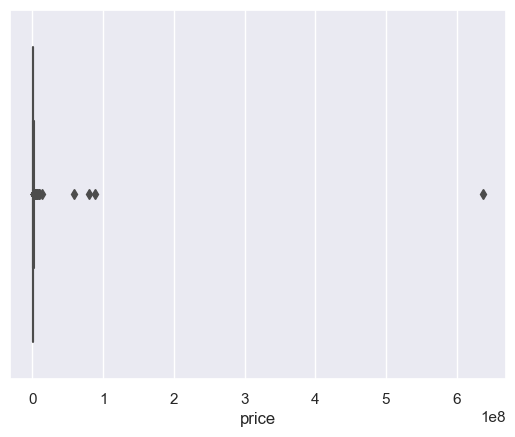

In [103]:
#boxlot
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(x=df['price'])
plt.show()
#drop outliers
df = df[df['price'] < 10000000]

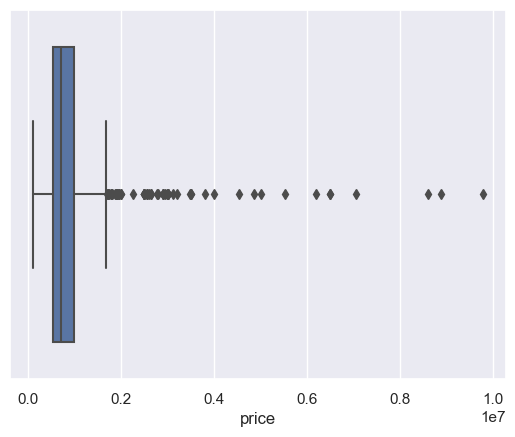

In [113]:
sns.boxplot(x=df['price'])
plt.show()

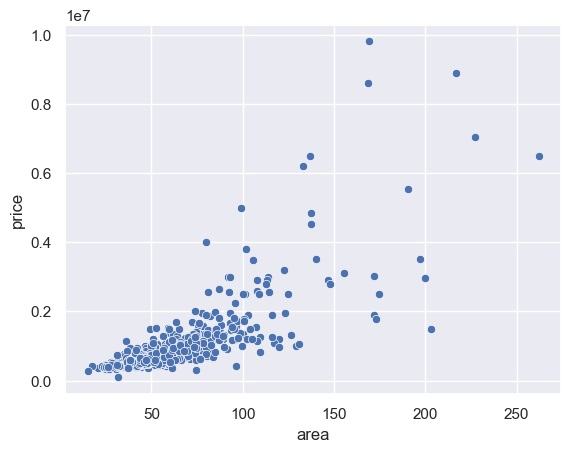

In [107]:
#plot area to price
sns.scatterplot(x=df['area'], y=df['price'])
# Set the tick locations and labels for the x-axis

plt.show()

In [108]:
#unique count of rooms
df['rooms'].value_counts()

2 pokoje    270
3 pokoje    241
4 pokoje     80
1 pokój      57
5 pokoi      20
6 pokoi       2
7 pokoi       1
Name: rooms, dtype: int64

In [109]:
df['forma_wlasnosci'].value_counts()

pełna własność               485
spółdzielcze własnościowe     51
spółdzielcze wł. z KW         34
udział                         3
Name: forma_wlasnosci, dtype: int64

In [110]:
df['parking'].value_counts()

garaż/miejsce parkingowe    378
Name: parking, dtype: int64

In [112]:
df['ogrzewanie'].value_counts()

miejskie       449
gazowe          40
inne            12
kotłownia        8
elektryczne      2
Name: ogrzewanie, dtype: int64